**Author** ::
Muhammad Hassan Mukhtar

**Affiliation** ::
The University of Salford, Manchester, England, UK

**Connect** ::
[GitHub](https://github.com/MHM-Rajpoot)
[LinkedIn](https://www.linkedin.com/in/-muhammad-hassan-mukhtar-/)

In [ ]:
!curl -s https://ollama.com/install.sh | bash

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
!pip install ollama langchain

`ollama serve`

In [ ]:
!ollama pull llama3.2:1b

ollama run llama3.2:1B

In [ ]:
!ollama --version

ollama version is 0.12.3


In [ ]:
!ollama list

NAME           ID              SIZE      MODIFIED      
llama3.2:1b    baf6a787fdff    1.3 GB    9 seconds ago    


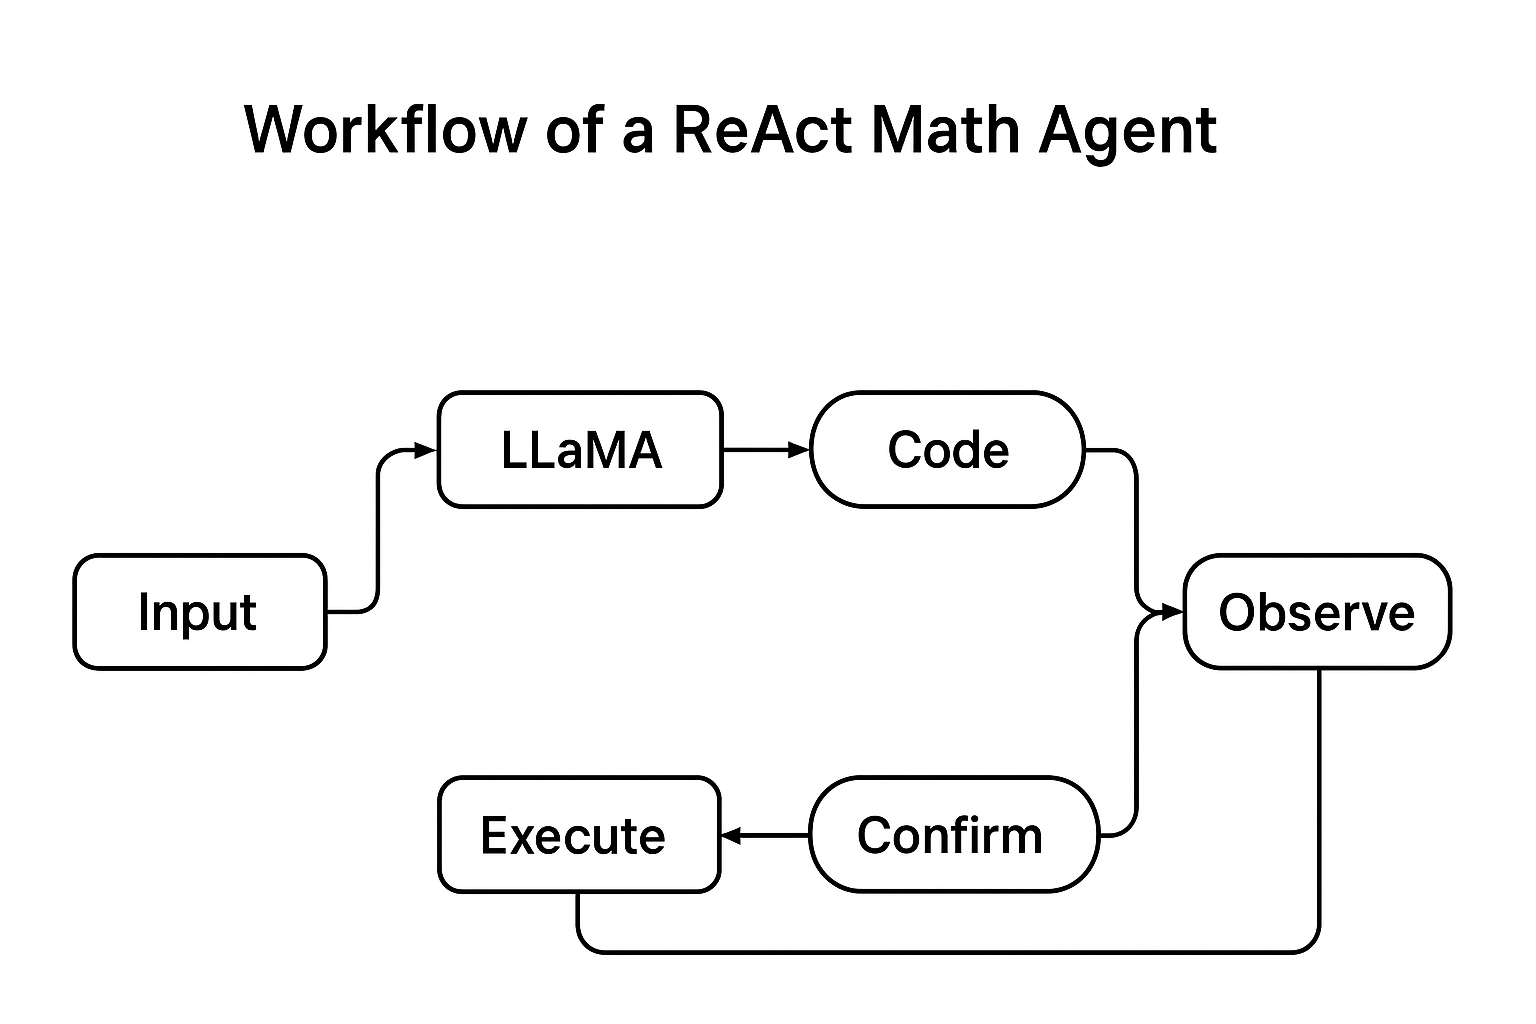

# Workflow of the ReAct Math Agent

## 1. User Input
- The agent asks the user for a math query (e.g., "What is (5+3)*2?").
- Input is logged:
  - **Console:** short line
  - **Log file:** detailed

## 2. Prompt Generation and Sending to LLaMA
- Construct a prompt instructing LLaMA to:
  - Reason step by step
  - Write Python code if needed
  - Observe outputs and continue reasoning until final answer
- Send prompt to LLaMA
- Log:
  - **Console:** short line
  - **Log file:** detailed

## 3. Receive LLaMA Response
- LLaMA generates:
  - Step-by-step reasoning in natural language
  - Optional Python code in markdown code blocks
- Log response:
  - **Console:** short form
  - **Log file:** full detail

## 4. Extract Python Code (Action Step)
- Parse LLaMA response
- Extract Python code inside ```python ... ``` blocks
- Save extracted code as `math_problem.py`
- Log extraction

## 5. Run Python Code and Observe Output
- Execute `math_problem.py` using `subprocess`
- Capture output
- Log:
  - **Console:** concise
  - **Log file:** detailed
- This is the Observation phase

## 6. Feed Observation Back to LLaMA
- Send execution output back to LLaMA
- LLaMA may:
  - Update reasoning
  - Modify code
  - Confirm final answer

## 7. Repeat Reason + Act Cycle
- Steps 3–6 repeat until LLaMA provides a `Final Answer`
- Each cycle includes:
  - Reasoning logged
  - Actions executed
  - Observations fed back

## 8. Finalize Answer
- Detect `Final Answer:` in LLaMA’s response
- Replace `<answer>` placeholder with actual Python output
- Log:
  - **Console:** short line
  - **Log file:** detailed

## Logging
- **Console:** short messages for each step
- **Log file (react_log.txt):** complete records of:
  - User input
  - Prompt sent to LLaMA
  - LLaMA reasoning
  - Extracted Python code
  - Python execution output
  - Observations fed back
  - Final confirmation

## Why This is a ReAct Agent
- **ReAct = Reason + Act**
- **Reasoning:** LLaMA explains steps in natural language
- **Acting:** Python code executed by agent
- **Observation:** Execution results captured and fed back
- **Iterative Loop:** Reason → Act → Observe → Reason until correct solution
- **Final Answer:** Verified and output after LLaMA confirmation


In [ ]:
import ollama
import subprocess
import re
import textwrap
import time

LOG_FILE = "react_log.txt"

# -------------------- Logging Functions --------------------
def log_console(message: str):
    """Print only short messages to console."""
    print(message)

def log_file(title: str, content: str):
    """Save full detailed logs to file only (no console)."""
    section_text = f"\n=== {title} ===\n{textwrap.indent(content.strip(), '  ')}\n"
    with open(LOG_FILE, "a") as f:
        f.write(section_text)

# -------------------- Helper Functions --------------------
def extract_code(response: str):
    return re.findall(r"```python(.*?)```", response, re.DOTALL)

def save_code(code: str) -> str:
    filename = f"math_problem.py"
    with open(filename, "w") as f:
        f.write(code)
    log_console(f"\n[Step] Created Python file: {filename}")  # short console log
    log_file("Python Code", code)  # detailed file log
    return filename

def run_code(filename: str) -> str:
    """
    Run Python file and ensure the result is printed.
    If no print exists, automatically append print for last variable.
    """
    try:
        # Read original code
        with open(filename, "r") as f:
            code = f.read()

        # Ensure code prints the last assigned variable if no print exists
        if "print(" not in code:
            # Find last variable assigned (simplistic)
            last_var = None
            for line in code.strip().splitlines()[::-1]:
                if "=" in line and not line.strip().startswith("#"):
                    last_var = line.split("=")[0].strip()
                    break
            if last_var:
                code += f"\nprint({last_var})"
                with open(filename, "w") as f:
                    f.write(code)

        # Run the code
        output = subprocess.check_output(["python", filename], stderr=subprocess.STDOUT)
        output_str = output.decode("utf-8").strip()

        log_console(f"[Step] Ran Python file: {filename} -> Output: {output_str}")
        log_file("Python Execution Output", output_str)
        return output_str

    except subprocess.CalledProcessError as e:
        err = e.output.decode("utf-8").strip()
        log_console(f"[Step] Python file error: {filename} -> {err}")
        log_file("Python Execution Output", err)
        return f"Error: {err}"

# -------------------- Main ReAct Agent with Auto-Code-Fix --------------------
def main():
    print("🔢 ReAct Math Agent running. Type 'exit' to quit.")
    open(LOG_FILE, "w").close()  # clear old log

    while True:
        user_input = input("\nQuery: ").strip()
        if user_input.lower() == "exit":
            break

        log_console(f"[Input] {user_input}")
        log_file("User Input", user_input)

        prompt = f"""
You are a ReAct agent (Reason + Act). Solve the following query step by step:

Query: "{user_input}"

Process:
1. Think step by step (Reason).
2. If needed, take an Action by writing Python code in ```python ... ``` blocks.
3. Observe the result.
4. Repeat Reason + Act until you can provide the correct solution.
5. Finish with: Final Answer: <answer>
"""
        messages = [{"role": "user", "content": prompt}]
        log_console("[Step] Sent query to LLaMA")
        log_file("Step 1: Prompt to LLaMA", prompt)

        final_answer_obtained = False

        while not final_answer_obtained:
            response = ollama.chat(model="llama3.2:1b", messages=messages)
            content = response["message"]["content"]
            log_console("[Step] LLaMA response received")
            log_file("Step 2: LLaMA Response", content)

            reasoning = re.split(r"```python.*?```", content, flags=re.DOTALL)[0]
            if reasoning.strip():
                log_file("Reasoning", reasoning)

            code_blocks = extract_code(content)

            if code_blocks:
                for code in code_blocks:
                    filename = save_code(code)
                    output = run_code(filename)

                    if output.startswith("Error:"):
                        # Send error back to LLaMA to fix the code
                        error_prompt = f"""
The previous Python code had an error when executed:

{output}

Please rewrite the code correctly to solve the query: "{user_input}".
Provide the fixed code in a ```python ... ``` block only.
"""
                        messages.append({"role": "assistant", "content": content})
                        messages.append({"role": "user", "content": error_prompt})
                        log_console("[Step] Sent error back to LLaMA to fix code")
                        log_file("Python Error Feedback", output)
                        break  # retry in next loop iteration
                    else:
                        # Successful execution → final answer
                        final_answer = output
                        log_console(f"[Final Answer] {final_answer}")
                        log_file("✅ Final Answer to User", final_answer)
                        final_answer_obtained = True
                        break
            else:
                # No code → continue reasoning
                messages.append({"role": "assistant", "content": content})
                messages.append({"role": "user", "content": "Continue reasoning."})

if __name__ == "__main__":
    main()

🔢 ReAct Math Agent running. Type 'exit' to quit.

Query: Matrix Multiplication of identity Matrix 3x3 and [1,5,9][3,5,7][4,5,6]
[Input] Matrix Multiplication of identity Matrix 3x3 and [1,5,9][3,5,7][4,5,6]
[Step] Sent query to LLaMA
[Step] LLaMA response received

[Step] Created Python file: math_problem.py
[Step] Python file error: math_problem.py -> Traceback (most recent call last):
  File "/content/math_problem.py", line 9, in <module>
    C = np.dot(I_3x3, B)
        ^^^^^^^^^^^^^^^^
ValueError: shapes (3,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)
[Step] Sent error back to LLaMA to fix code
[Step] LLaMA response received

[Step] Created Python file: math_problem.py
[Step] Ran Python file: math_problem.py -> Output: [[1 5 9]
 [3 5 7]
 [4 5 6]]
[Final Answer] [[1 5 9]
 [3 5 7]
 [4 5 6]]


KeyboardInterrupt: Interrupted by user

Queries Tested

1. What is (5+3)*2?
2. Add numbers form 1 to 10
3. Matrix Multiplication of identity Matrix 3x3 and [1,5,9][3,5,7][4,5,6]